In [2]:
from tqdm import tqdm
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2gray
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import nrrd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from torch.utils import data
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from torchvision import datasets, transforms, models

#### Load Data

In [3]:
x_train, header = nrrd.read("../processed/normal_abnormal/x_train.nrrd")
y_train, header = nrrd.read("../processed/normal_abnormal/y_train.nrrd")
x_valid, header = nrrd.read("../processed/normal_abnormal/x_valid.nrrd")
y_valid, header = nrrd.read("../processed/normal_abnormal/y_valid.nrrd")

In [4]:
# Transform to torch tensor
tensor_train_x = torch.Tensor(x_train)
tensor_train_y = torch.Tensor(y_train)
tensor_valid_x = torch.Tensor(x_valid)
tensor_valid_y = torch.Tensor(y_valid)

trainset = data.TensorDataset(tensor_train_x, tensor_train_y)
validset = data.TensorDataset(tensor_valid_x, tensor_valid_y)
trainloader = data.DataLoader(trainset, batch_size=5, shuffle=True)
validloader = data.DataLoader(validset, batch_size=5, shuffle=True)

#### Check for CUDA

In [5]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    device = torch.device("cpu")
    print("Running on CPU")
else:
    device = torch.device("cuda:0")
    print("CUDA is available!")

CUDA is available!


In [6]:
model = models.resnet18(pretrained=False)

In [7]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
classifier = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2))

In [9]:
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = classifier

In [10]:
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

#### Train Model

In [ ]:
n_epochs = 200
valid_loss_min = np.Inf
train_losses, valid_losses = [], []

for epoch in range(n_epochs):
    # Define Constants
    train_loss = 0.0
    valid_loss = 0.0
    accuracy = 0.0
    epoch_loss = []
   
    for data, target in trainloader:
        # Put data on GPU
        data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.long)
        optimizer.zero_grad()
        output = model(data)
        # Compute loss
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss.append(float(loss.item()*data.size(0)))
        train_loss += loss.item()*data.size(0)
    
    # Check if learning rate needs to be updated
    scheduler.step(np.mean(epoch_loss))
    with torch.no_grad():
        model.eval() # Turn dropout off
        for data, target in validloader:
            data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.long)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            # Calculating accuracy
            ps = torch.exp(F.log_softmax(output, dim=1))
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
            
    model.train()
    # Calculate average loss and accuracy
    train_loss = train_loss/len(trainloader)
    valid_loss = valid_loss/len(validloader)
    accuracy = accuracy/len(validloader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print("Epoch:{}\t Training Loss:{:.6f}\t Validation Loss: {:.6f}\t Accuracy: {:.6f}".format(epoch, train_loss, valid_loss, accuracy))
    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(valid_loss_min, valid_loss))
        print("-"*40)
        # Save model
        torch.save(model.state_dict(), 'model_checkpoints/resnet18_model_2Class_normal_abnormal_imgNet_Weights.pth')
        valid_loss_min = valid_loss

Epoch:0	 Training Loss:2.847258	 Validation Loss: 2.196882	 Accuracy: 0.824168
Validation loss decreased (inf --> 2.196882).  Saving model ...
----------------------------------------
Epoch:1	 Training Loss:2.432472	 Validation Loss: 2.099626	 Accuracy: 0.821667
Validation loss decreased (2.196882 --> 2.099626).  Saving model ...
----------------------------------------
Epoch:2	 Training Loss:2.255127	 Validation Loss: 2.099445	 Accuracy: 0.820001
Validation loss decreased (2.099626 --> 2.099445).  Saving model ...
----------------------------------------
Epoch:3	 Training Loss:2.195527	 Validation Loss: 1.924987	 Accuracy: 0.850834
Validation loss decreased (2.099445 --> 1.924987).  Saving model ...
----------------------------------------
Epoch:4	 Training Loss:2.243267	 Validation Loss: 1.841791	 Accuracy: 0.840001
Validation loss decreased (1.924987 --> 1.841791).  Saving model ...
----------------------------------------
Epoch:5	 Training Loss:2.172706	 Validation Loss: 1.908970	 

Epoch:81	 Training Loss:1.716791	 Validation Loss: 1.465530	 Accuracy: 0.887501
Epoch:82	 Training Loss:1.707719	 Validation Loss: 1.454380	 Accuracy: 0.889168
Epoch:83	 Training Loss:1.753211	 Validation Loss: 1.460699	 Accuracy: 0.885001
Epoch:84	 Training Loss:1.660341	 Validation Loss: 1.457976	 Accuracy: 0.886667
Epoch:85	 Training Loss:1.658403	 Validation Loss: 1.463453	 Accuracy: 0.887501
Epoch:86	 Training Loss:1.664626	 Validation Loss: 1.459933	 Accuracy: 0.887501
Epoch:87	 Training Loss:1.698479	 Validation Loss: 1.462127	 Accuracy: 0.885001
Epoch:88	 Training Loss:1.717164	 Validation Loss: 1.487246	 Accuracy: 0.884168
Epoch:89	 Training Loss:1.668588	 Validation Loss: 1.453148	 Accuracy: 0.886667
Epoch:90	 Training Loss:1.638568	 Validation Loss: 1.461433	 Accuracy: 0.883334
Epoch:91	 Training Loss:1.655569	 Validation Loss: 1.489808	 Accuracy: 0.885834
Epoch:92	 Training Loss:1.676597	 Validation Loss: 1.463777	 Accuracy: 0.887501
Epoch:93	 Training Loss:1.660619	 Valida

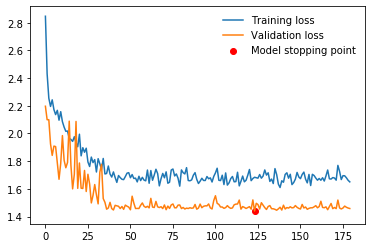

In [5]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.scatter(123, 1.440257, c='red', label='Model stopping point')
plt.legend(frameon=False)
plt.savefig('resnet18_2Class_loss_normal_abnormal.png')

### Make Predictions

In [12]:
# Load weights to model
weights = torch.load('resnet18_model_2Class_normal_abnormal_imgNet_Weights.pth')
model.load_state_dict(weights)

<All keys matched successfully>

In [13]:
final_predicted_array = []
groundTruth = []

# Evaluation mode
with torch.no_grad():
    model.eval()
    for data, target in validloader:
        data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.long)
        groundTruth.extend(target.data.cpu().numpy())
        output = model(data)
        ps = torch.exp(F.log_softmax(output, dim=1))
        top_p, top_class = ps.topk(1, dim=1)
        final_predicted_array.extend(top_class.data.cpu().numpy())

In [14]:
target_names = ["Normal", "Abnormal"]
print(classification_report(groundTruth, final_predicted_array, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.88      0.91      0.89       613
    Abnormal       0.91      0.87      0.89       587

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200



In [15]:
fpr, tpr, thresholds = roc_curve(groundTruth, final_predicted_array)
auc = roc_auc_score(groundTruth, final_predicted_array)
print("AUC on Test Set:",auc)

AUC on Test Set: 0.8894786719321014


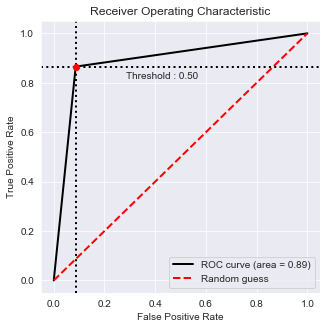

<Figure size 432x288 with 0 Axes>

In [16]:
from plot_metric.functions import BinaryClassification
bc = BinaryClassification(groundTruth, final_predicted_array, labels=["Pneumonia", "Covid"])

plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()
plt.savefig('normal_abnormal_resent18roc.png')